## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [31]:
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import Softmax
from torch.nn import ELU

from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torch

from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

# Init
torch.cuda.init()

def get_fashion_dataset_transform():
    dataset = FashionMNIST("./fashion_mnist", train=True, download=True, transform=transforms.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=3)
    mean = torch.zeros(1)
    std = torch.zeros(1)
    divider = 0
    for batch, _ in iter(dataloader):
        mean += batch.cuda().mean()
        std += batch.cuda().std()
        divider += 1
    mean /= divider
    std /= divider
    return transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

transformer = get_fashion_dataset_transform()

train_dataset = FashionMNIST("./fashion_mnist", train=True, download=True, transform=transformer)
test_dataset = FashionMNIST("./fashion_mnist", train=False, download=True, transform=transformer)

In [32]:
def visualize(loss, accuracy):    
    plt.clf()

    #plt.subplot(2,1,1)
    #images = make_grid(X)
    #plt.imshow(((images + 1) / 2).numpy())

    plt.subplot(1,2,1)
    plt.title("Accuracy")
    plt.plot(accuracy[:, 0], label="Train")
    plt.plot(accuracy[:, 1], label="Test")
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0., 1.)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title("Loss")
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)    

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def train(model, optim, loss_function, train_loader, test_loader, epoches=100, test_batches_ctn=8):
    loss_array = np.zeros(epoches)
    accuracy = np.zeros((epoches, 2))
    
    plt.figure(figsize=(16,5))
    
    for epoch in range(epoches):
        for data, labels in iter(train_loader):
            optim.zero_grad()
            loss = loss_function(model(data.cuda()), labels.cuda())
            loss.backward()
            optim.step()
        
        train_loader_iter = iter(train_loader)
        test_loader_iter = iter(test_loader)
        avg_loss = 0.
        avg_train_accuracy = 0.
        avg_test_accuracy = 0.
        
        for _ in range(test_batches_ctn):
            train_data, train_labels = train_loader_iter.next()
            test_data, test_labels = test_loader_iter.next()
            train_pred = model(train_data.cuda())
            test_pred = model(test_data.cuda())
            loss = loss_function(train_pred, train_labels.cuda())
            avg_loss += loss.item()
            avg_train_accuracy += (torch.max(train_pred, 1)[1] == train_labels.cuda()).sum().item() / len(train_data)
            avg_test_accuracy += (torch.max(test_pred, 1)[1] == test_labels.cuda()).sum().item() / len(test_data)
        
        loss_array[epoch] = avg_loss / test_batches_ctn
        accuracy[epoch][0] = avg_train_accuracy / test_batches_ctn
        print(avg_train_accuracy / test_batches_ctn)
        accuracy[epoch][1] = avg_test_accuracy / test_batches_ctn
        visualize(loss_array, accuracy)
    plt.clf()
    return accuracy

In [56]:
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class FashionConvolutionModule(Module):
    def __init__(self, classes_count, channels=1):
        super().__init__()
        self.seq = Sequential(
            Conv2d(channels, 20, (5, 5), 1), ELU(),
            Conv2d(20, 30, (5, 5), 3), ELU(),
            Flatten(), Linear(1470, 200), ELU(),
            Linear(200, classes_count), Softmax()
        )

    def forward(self, input):
        return self.seq(input)

model = FashionConvolutionModule(10)
model.cuda()
loss_function = CrossEntropyLoss()
opt = Adam(model.parameters())

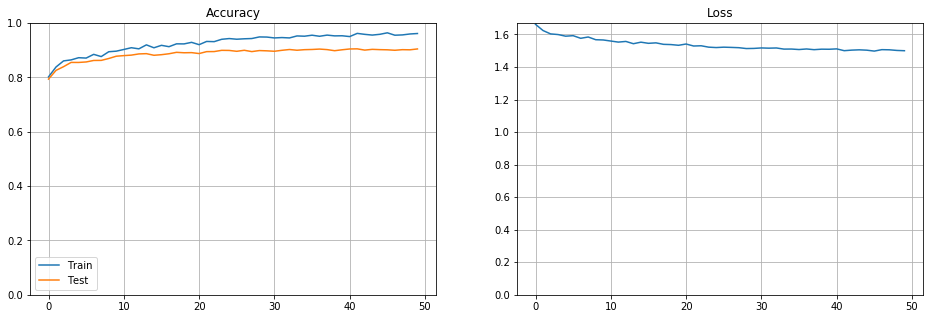

Max test accuracy: 0.9049072265625


In [57]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True, num_workers=3)

acc = train(model, opt, loss_function, train_loader, test_loader, epoches=50)
print("Max test accuracy:", max(acc[:, 1]))